# Import libraries

In [56]:
!pip3 install linformer pytorch-lightning

from __future__ import print_function

import glob
from itertools import chain
import os
import random

import zipfile
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from IPython.display import clear_output

from vit_pytorch.efficient import ViT

# Captum packages
from captum.attr import *

from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

In [2]:
print(f"Torch: {torch.__version__}")


Torch: 1.11.0


# Set seeds

In [2]:
# Training settings
batch_size = 64
epochs = 5
lr = 3e-5
gamma = 0.7
seed = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
device = 'cuda'


# Load and prepare data

In [5]:
PATH = "../reproducibility/acm_full_pdfs/pdfs_to_imgs/"
#%mkdir ../reproducibility/acm_full_pdfs/abstractImgs
PATHabstract = "../reproducibility/acm_full_pdfs/abstractImgs/"

In [6]:
#Load the labels
dfLabels = pd.read_csv("../data_make/labelData.csv").drop(columns="Unnamed: 0")

In [7]:
dfLabels.head()
dfLabels.columns

Index(['fileName', 'Artifacts Available', 'Artifacts Evaluated & Functional',
       'Artifacts Evaluated & Reusable', 'Best Artifact',
       'Best Industry Paper', 'Best Paper', 'Best Student Paper',
       'Distinguished Paper', 'Results Reproduced'],
      dtype='object')

In [8]:
mkdir ../reproducibility/acm_full_pdfs/abstractImgs/

mkdir: cannot create directory ‘../reproducibility/acm_full_pdfs/abstractImgs/’: File exists


In [9]:
# train_dir = 'data/train'
test_dir = 'data/test'

In [10]:
# For copying first page from PATH to PATHabstract directory

for imgP in glob.glob(os.path.join(PATH, "*_0*")):
    fileName = "".join(imgP.split("_0")).split("/")[-1].strip(".png")
    print(fileName)
    if fileName in dfLabels.fileName.values:
        shutil.copy(imgP, os.path.join(PATHabstract, fileName +'.png'))    
    clear_output(wait=True)

3377811.3380343


In [11]:
train_list = glob.glob(os.path.join(PATHabstract,'*.png'))
test_list = glob.glob(os.path.join(PATHabstract, '*.png'))

In [12]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")
train_fileNames = [tl.strip(".png").split("/")[-1] for tl in train_list]

Train Data: 1107
Test Data: 1107


In [13]:
labels = train_fileNames

NameError: name 'idx' is not defined

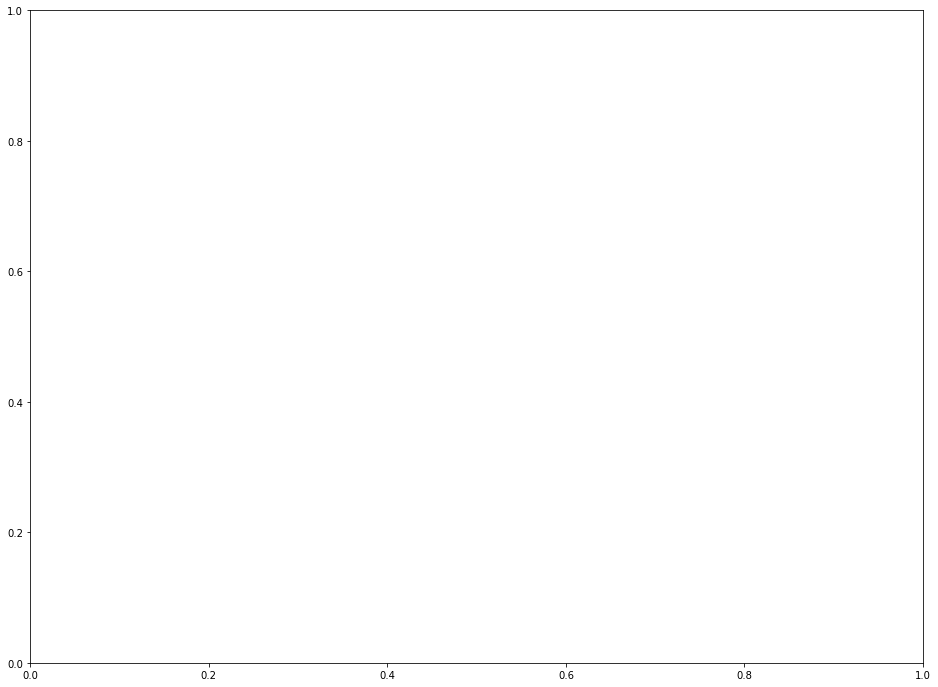

In [14]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(1, 1, figsize=(16, 12))

#for idx, ax in enumerate(axes):
img = Image.open(train_list[idx])
axes.set_title(labels[0])
axes.imshow(img)


In [17]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          random_state=seed)

In [18]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 885
Validation Data: 222
Test Data: 1107


In [19]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [20]:
class reproduceDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        # label = img_path.split("/")[-1].split(".")[0]
        # label = 1 if label == "dog" else 0
        label = img_path.strip(".png").split("/")[-1]
        label=dfLabels[dfLabels["fileName"]==label].drop(columns = "fileName").values
        return img_transformed, label

In [21]:
train_data = reproduceDataset(train_list, transform=train_transforms)
valid_data = reproduceDataset(valid_list, transform=test_transforms)
test_data = reproduceDataset(test_list, transform=test_transforms)

In [22]:
# 
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

# Define Transformer

In [23]:
print(len(train_data), len(train_loader))

885 14


In [24]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)


In [25]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=9,
    transformer=efficient_transformer,
    channels=3,
)#.to(device)

In [26]:
# loss function
criterion = nn.MultiLabelSoftMarginLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

# Fine-tune Transformer

In [27]:
from sklearn.metrics import accuracy_score

def compute_accuracy(output_fn, label_fn):
    accuracies = []
    for i in range(9):    
        print(output_fn.shape)
        outputSlice = np.take(output_fn,i, axis=1)>0.5#.shape
        outputSlice = score.astype(int)
        
        labelSlice = np.take(label_fn,i, axis=1)
        
#         print(outputSlice.shape)
#         print(outputSlice)
#         print(labelSlice.shape)
#         print(labelSlice)
        outputSlice = outputSlice[:len(labelSlice)]
        accuracies.append(accuracy_score(labelSlice, outputSlice))
    return accuracies

In [ ]:
import tqdm
from sklearn.metrics import f1_score

for epoch in tqdm.tqdm(range(epochs)):
    epoch_loss = 0
    epoch_accuracy = 0

    for train_data,  train_label in tqdm.tqdm(train_loader):
        train_data = train_data#.to(device)
        #train_label =  train_label#.to(device)

        train_output = model( train_data)
        loss = criterion( train_output,  train_label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(output)
        # acc = (output.argmax(dim=1) == label).float().mean()
        train_output =train_output.detach().numpy()
        train_label = train_label.detach().numpy().squeeze()
        
        print("in the loop")
        
        print( train_output.shape,  train_label.shape)

        epoch_accuracy=compute_accuracy( train_output,train_label  )
        #epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        #print(epoch_accuracy)
        clear_output(wait=True)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for val_data, val_label in valid_loader:
            #data = data#.to(device)
            #label = label#.to(device)
            
            val_output = model(val_data)
            val_loss = criterion(val_output, val_label)
            #print(val_output)
            
            #acc = (val_output.argmax(dim=1) == label).float().mean()
            #epoch_val_accuracy += acc / len(valid_loader)
            
            # acc = f1_score(label, output > 0.5)
            val_output = val_output.detach().numpy()
            val_label = val_label.detach().numpy().squeeze()
            print(val_output.shape, val_label.shape)
            epoch_val_accuracy = compute_accuracy(val_output, val_label)
            epoch_val_loss += val_loss / len(valid_loader)
            
    for i in range(9):
        print(
            f"Class : {i} Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy[i]:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy[i]:.4f}\n"
        )
    print()

In [ ]:
label.shape
np.take(label.detach().numpy().squeeze(),0, axis=1).shape

In [ ]:
# for train_data, train_label in train_loader:
#     print(train_label.detach().numpy().squeeze().shape)
#     print(model(train_data).detach().numpy().shape)
# model.predict(train_)

In [ ]:
torch.save(model.state_dict(), 'model.h5')

# Load trained model

In [30]:
efficient_transformer1 = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)
model1 = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=9,
    transformer=efficient_transformer1,
    channels=3,
)#.to(device)

In [31]:
model1.load_state_dict(torch.load('model'))
model1.eval()


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=128, bias=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (w1): Linear(in_features=128, out_features=512, bias=True)
              (act): GELU()
              (dropout)

# Load representative samples

In [140]:
#All data 
whichLabels = dfLabels.drop(columns= 'fileName').values
#train data only
whichLabels = [label[0] for data,label in train_data]
#test data only
whichLabels = [label[0] for data,label in test_data]

defineStr = np.array(["".join(str(row)) for row in whichLabels])
print(dfLabels.columns)
import pprint
pprint.pprint(Counter(defineStr))

Index(['fileName', 'Artifacts Available', 'Artifacts Evaluated & Functional',
       'Artifacts Evaluated & Reusable', 'Best Artifact',
       'Best Industry Paper', 'Best Paper', 'Best Student Paper',
       'Distinguished Paper', 'Results Reproduced'],
      dtype='object')
Counter({'[1 0 1 0 0 0 0 0 0]': 385,
         '[1 0 0 0 0 0 0 0 0]': 148,
         '[1 1 0 0 0 0 0 0 0]': 118,
         '[1 1 1 0 0 0 0 0 0]': 74,
         '[1 1 0 0 0 0 0 0 1]': 67,
         '[1 0 1 0 0 0 0 0 1]': 53,
         '[1 0 0 0 0 0 0 0 1]': 10,
         '[1 0 1 0 0 0 0 1 0]': 7,
         '[1 1 1 0 0 0 0 1 0]': 7,
         '[1 0 1 0 0 1 0 0 1]': 3,
         '[1 1 0 0 0 1 0 0 0]': 3,
         '[1 1 0 1 0 0 0 0 1]': 2,
         '[1 0 0 0 0 0 0 1 0]': 2,
         '[1 0 1 0 1 0 0 0 0]': 1,
         '[1 0 1 1 0 0 0 0 1]': 1,
         '[1 1 0 0 0 0 1 0 0]': 1,
         '[1 0 0 0 0 0 1 0 0]': 1,
         '[1 1 0 0 0 0 0 1 0]': 1,
         '[1 1 1 0 0 1 0 0 0]': 1})


In [141]:
print(dfLabels.columns)
import pprint
pprint.pprint(Counter(defineStr))

Index(['fileName', 'Artifacts Available', 'Artifacts Evaluated & Functional',
       'Artifacts Evaluated & Reusable', 'Best Artifact',
       'Best Industry Paper', 'Best Paper', 'Best Student Paper',
       'Distinguished Paper', 'Results Reproduced'],
      dtype='object')
Counter({'[1 0 1 0 0 0 0 0 0]': 385,
         '[1 0 0 0 0 0 0 0 0]': 148,
         '[1 1 0 0 0 0 0 0 0]': 118,
         '[1 1 1 0 0 0 0 0 0]': 74,
         '[1 1 0 0 0 0 0 0 1]': 67,
         '[1 0 1 0 0 0 0 0 1]': 53,
         '[1 0 0 0 0 0 0 0 1]': 10,
         '[1 0 1 0 0 0 0 1 0]': 7,
         '[1 1 1 0 0 0 0 1 0]': 7,
         '[1 0 1 0 0 1 0 0 1]': 3,
         '[1 1 0 0 0 1 0 0 0]': 3,
         '[1 1 0 1 0 0 0 0 1]': 2,
         '[1 0 0 0 0 0 0 1 0]': 2,
         '[1 0 1 0 1 0 0 0 0]': 1,
         '[1 0 1 1 0 0 0 0 1]': 1,
         '[1 1 0 0 0 0 1 0 0]': 1,
         '[1 0 0 0 0 0 1 0 0]': 1,
         '[1 1 0 0 0 0 0 1 0]': 1,
         '[1 1 1 0 0 1 0 0 0]': 1})


In [168]:
from collections import Counter
print()
print("Indices of : 'Artifacts Available', 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' ")
print(np.where(defineStr=='[1 0 0 0 0 0 0 0 0]'))
print()
print("Indices of : 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' ")
print(np.where(defineStr=='[1 0 1 0 0 0 0 0 0]'))


Indices of : 'Artifacts Available', 'Artifacts Evaluated & Functional' +  'Artifacts Evaluated & Reusable' + 'Results Reproduced' 
(array([  2,  11,  16,  30,  37,  41,  50,  56,  58,  61,  66,  67,  76,
        82,  83,  84,  89, 100, 103, 110, 111, 112, 113, 115, 120, 124,
       131, 134, 137, 141, 143, 150, 155, 156, 162, 170, 174, 180, 190,
       191, 196, 197, 207, 219, 224, 235, 236, 237, 245, 247, 248, 251,
       257, 259, 262, 266, 270, 273, 300, 302, 307, 313, 329, 336, 339,
       348, 350, 351, 355, 358, 369, 379, 394, 400, 402, 406, 414, 418,
       440, 452, 466, 472, 484, 491, 493, 496, 502, 505, 507, 508, 509,
       535, 544, 549, 552, 555, 558, 567, 571, 574, 578, 583, 585, 600,
       602, 618, 647, 650, 652, 660, 665, 674, 682, 686, 718, 729, 732,
       754, 758, 762, 764, 770, 774, 777, 780, 785, 790, 803, 804, 805,
       806, 811, 816, 820, 824, 826, 830, 837, 839, 853, 856, 859, 860,
       862, 863, 870, 872, 884]),)

Indices of : 'Artifacts Evaluated & Fun

In [171]:
print(train_data[326][0].shape)
model1(train_data[6][0].unsqueeze(0))

torch.Size([3, 224, 224])


tensor([[ 2.9889, -0.6382,  0.3684, -3.2985, -3.2524, -3.0950, -3.1140, -2.9981,
         -1.6049]], grad_fn=<AddmmBackward0>)

# Model Interpretation

## Integrated gradients

In [32]:
# Pick a sample you want to explain
nSample = 301
inputData = train_data[nSample][0]#.detach().cpu()
label = train_data[nSample][1]

In [33]:
ig = IntegratedGradients(model1)
baseline = torch.rand(1,3,224,224)
attributions, delta = ig.attribute(inputData.unsqueeze(axis=0), target=1, return_convergence_delta=True)

In [34]:
inputDataNum = np.rollaxis(inputData.detach().numpy().squeeze(), 0,3)
attributionsNum = np.rollaxis(attributions.detach().numpy().squeeze(), 0,3)

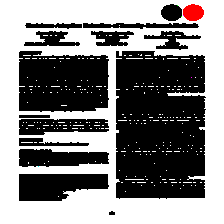

<Figure size 532.8x576 with 0 Axes>

In [35]:
inputDataNum = inputDataNum.astype(np.uint8)
fig = plt.figure()
fig.set_size_inches(7.4,8)
Image.fromarray(inputDataNum*255)
# plt.imshow()
# plt.show()

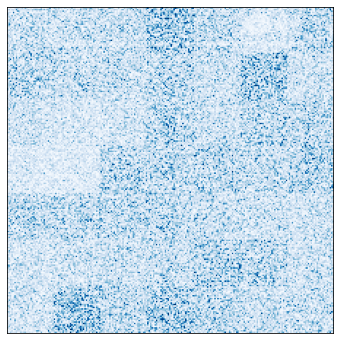

In [36]:
_ = visualization.visualize_image_attr(np.rollaxis(attributions.detach().numpy().squeeze(),0,3), np.rollaxis(inputData.detach().numpy(),0,3), method="heat_map", )
# plt.show()

## Saliency maps

In [37]:
inputData.shape

torch.Size([3, 224, 224])

In [38]:

# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
#net = ImageClassifier()
# Generating random input with size 2x3x3x32
input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Defining Saliency interpreter
saliency = Saliency(model1)
# Computes saliency maps for class 3.
attribution = saliency.attribute(inputData.unsqueeze(axis=0), target=3)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


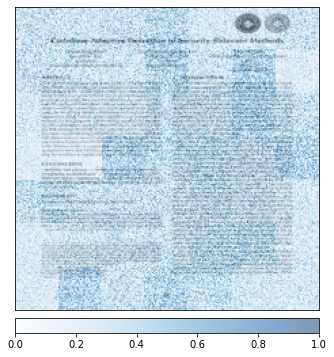

In [39]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## DeepLift

In [32]:


# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
dl = DeepLift(model1)
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes deeplift attribution scores for class 3.
attribution = dl.attribute(inputData.unsqueeze(axis=0), target=3)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


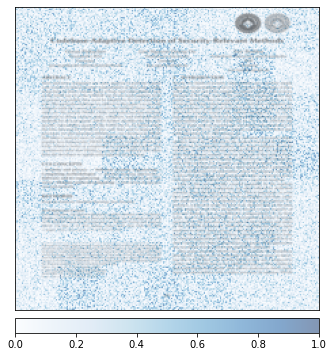

In [33]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## DeepLiftSHAP

In [48]:
(inputData.unsqueeze(axis=0)*0).shape

torch.Size([1, 3, 224, 224])

In [51]:

# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
baseline = torch.rand(2,3,224,224)

dl = DeepLiftShap(model1)
# input = torch.randn(2, 3, 32, 32, requires_grad=True)
# Computes deeplift attribution scores for class 3.
attribution = dl.attribute(inputData.unsqueeze(axis=0),baselines=baseline, target=0)

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


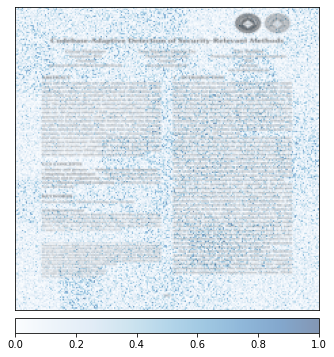

In [52]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

## GradientSHAP

In [61]:
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
baseline = torch.rand(2,3,224,224)

gradient_shap = GradientShap(model1)
#input = torch.randn(3, 3, 224, 32, requires_grad=True)
# choosing baselines randomly
#baselines = torch.randn(20, 3, 32, 32)
# Computes gradient shap for the input
# Attribution size matches input size: 3x3x32x32
attribution = gradient_shap.attribute(inputData.unsqueeze(0), baseline,
                                                    target=5)

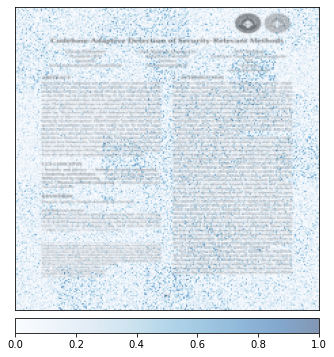

In [62]:
_ = visualization.visualize_image_attr(np.rollaxis(attribution.detach().numpy().squeeze(),0,3), 
                                       np.rollaxis(inputData.detach().numpy(),0,3),
                                       method="blended_heat_map",show_colorbar = True)

# All attributions

In [234]:

def visualize_attributions(inputData,attribution,figName):
    dataPoint = np.rollaxis(inputData.detach().numpy(),0,3)
    
    fig, axs = plt.subplots(1,2)
    ax1= axs[0]
    ax2 = axs[1]
    ax2.imshow(dataPoint)
    ax2.set_xticks([])
    ax2.set_yticks([])
    v = visualization.visualize_image_attr(attribution, 
                                       dataPoint,
                                       method="heat_map",
                                       show_colorbar = True,
                                    use_pyplot=True,
                                    plt_fig_axis = (fig,ax1))

    fig.savefig(figName)
    plt.show()    
    return v

def get_attribution(inputData, target, mode):
    models = {
    'integrated_gradients': IntegratedGradients,
    'saliency' : Saliency,
    'deep_lift' : DeepLift,
    'deep_lift_shap' : DeepLiftShap,
    'gradient_shap' : GradientShap,
    'input_x_gradient' : InputXGradient,
    'guided_backprop' : GuidedBackprop,
    'guided_gradcam' : GuidedGradCam,
    'deconvolution' : Deconvolution,
    'feature_ablation' : FeatureAblation,
    'occlusion': Occlusion
    }
    
    dataPoint = inputData.unsqueeze(0)
    
    model = models[mode](model1)
    if mode=='occlusion':
        attribution = attr = model.attribute(dataPoint, target=target, sliding_window_shapes=(3,3))
        
    elif mode in ['deep_lift_shap','gradient_shap']:
        baseline = torch.rand(2,3,224,224)
        attribution = model.attribute(dataPoint, baseline,
                                                        target=target)
    else:
        attribution = model.attribute(dataPoint, target=target)
    
    return np.rollaxis(attribution.detach().numpy().squeeze(),0,3)


def load_input(nSample, train_data):
    inputData = train_data[nSample][0]#.detach().cpu()
    label = train_data[nSample][1]
    return inputData, label

def interpret_model(nSample, train_data, target, mode,model, figName):
    inputData, label = load_input(nSample, train_data)
    attribution = get_attribution(inputData, target, mode)
    vis = visualize_attributions(inputData, attribution, figName)
    

/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/devesh/anaconda3/envs/reproducePy/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


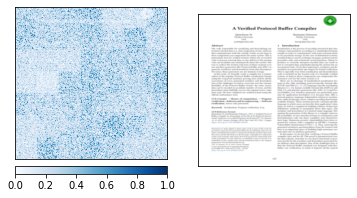

In [239]:
interpret_model(nSample=600, 
                train_data=train_data,
                target=0,
                mode='deep_lift',
                model=model1,
               figName="artifacts.png")

/usr/lib/python2.7/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: Python 2 is no longer supported by the Python core team. Support for it is now deprecated in cryptography, and will be removed in a future release.
  from cryptography.utils import int_from_bytes
DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
Defaulting to user installation because normal site-packages is not writeable


ModuleNotFoundError: No module named 'matplotlib_venn'

In [208]:
test_loader

# Insights

In [48]:
def formatted_data_iter():  
    # dataset = torchvision.datasets.CIFAR10(
    #     root="data/test", train=False, download=True, transform=transforms.ToTensor()
    # )
    # dataloader = iter(
    #     torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
    # )
    while True:
        images, labels = next(iter(train_loader))
        
        yield Batch(inputs=images, labels=labels)

In [50]:
i,l = next(iter(train_loader))

torch.Size([64, 1, 9])

In [46]:


def baseline_func(input):
    return input*0

def full_img_transform(input):
    return input.unsqueeze(0)
    
visualizer = AttributionVisualizer(
            
            models = [model1],
            
            classes = list(dfLabels.drop(columns = 'fileName').columns),
            features = [
            ImageFeature(
                "Photo",
            baseline_transforms = [baseline_func],
            input_transforms= [full_img_transform])
            ],
            
            dataset = formatted_data_iter(),
)



In [47]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['Artifacts Available', 'Artifacts Evaluated & Functional', 'Artifa…

Output()

In [513]:
!conda install freetype=2.10.4

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - pytorch/noarch::captum==0.5.0=0
  - conda-forge/noarch::transformers==4.16.2=pyhd8ed1ab_0
  - pytorch/linux-64::torchvision==0.12.0=py310_cu102
  - pytorch/linux-64::torchaudio==0.11.0=py310_cu102
  - conda-forge/linux-64::pytorch==1.11.0=cpu_py310h2272b30_0
done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/devesh/anaconda3/envs/reproducePy

  added / updated specs:
    - freetype=2.10.4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    freetype-2.10.4            |       h5ab3b9f_0         596 KB
    --------------------------------------------------

# Metrics

In [218]:
with torch.no_grad():
    
    for test_data, test_label in test_loader:
        #data = data#.to(device)
        #label = label#.to(device)

        test_output = model1(test_data)
        # val_loss = criterion(test_output, test_label)
        #print(val_output)

        #acc = (test_output.argmax(dim=1) == label).float().mean()
        #epoch_val_accuracy += acc / len(valid_loader)

        # acc = f1_score(label, output > 0.5)
        test_output = test_output.detach().numpy()
        test_label = test_label.detach().numpy().squeeze()
        print(test_output.shape, test_label.shape)
        
        # epoch_val_accuracy = compute_accuracy(val_output, val_label)
        # epoch_val_loss += val_loss / len(valid_loader)

(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(64, 9) (64, 9)
(19, 9) (19, 9)


In [224]:
test_data.shape

torch.Size([19, 3, 224, 224])

# def compute_accuracy(output_fn, label_fn):
    accuracies = []
    for i in range(9):    
        print(output_fn.shape)
        outputSlice = np.take(output_fn,i, axis=1)>0.5#.shape
        outputSlice = score.astype(int)
        
        labelSlice = np.take(label_fn,i, axis=1)
        
#         print(outputSlice.shape)
#         print(outputSlice)
#         print(labelSlice.shape)
#         print(labelSlice)
        outputSlice = outputSlice[:len(labelSlice)]
        accuracies.append(accuracy_score(labelSlice, outputSlice))
    return accuracies